<a href="https://colab.research.google.com/github/jmq19950824/Machine-Learning-with-Python/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision.models import vgg19
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
imsize=512
is_cuda=torch.cuda.is_available()

In [0]:
prep=transforms.Compose([transforms.Resize(imsize),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
            transforms.Normalize(mean=[0.40760392,0.45795686,0.48501961],std=[1,1,1]),
            transforms.Lambda(lambda x:x.mul_(255))])


In [0]:
postpa=transforms.Compose([transforms.Lambda(lambda x:x.mul_(1./255)),
             transforms.Normalize(mean=[-0.40760392,-0.45795686,-0.48501961],std=[1,1,1]),
             transforms.Lambda(lambda x:x[torch.LongTensor([2,1,0])])])

postpb=transforms.Compose([transforms.ToPILImage()])

In [0]:
def postp(tensor):
  t=postpa(tensor)
  t[t>1]=1
  t[t<0]=0
  img=postpb(t)
  return img

In [0]:
def image_loader(image_name):
  image=Image.open(image_name)
  image=Variable(prep(image))
  image=image.unsqueeze(0)
  return image

In [0]:
content_img=image_loader('/content/drive/My Drive/Book Codes/PyTorch深度学习/Style Transfer/nature.jpg')
style_img=image_loader('/content/drive/My Drive/Book Codes/PyTorch深度学习/Style Transfer/style_pic.jpg')

if is_cuda:
  content_img=content_img.cuda()
  style_img=style_img.cuda()

In [0]:
opt_img=Variable(content_img.data.clone(),requires_grad=True)

In [0]:
from torchvision.models import vgg19
#only use the feature module (not classifier)
vgg=vgg19(pretrained=True).features

#freeze the parameters
for param in vgg.parameters():
  param.requires_grad=False

if is_cuda:
  vgg=vgg.cuda()

In [0]:
content_layers=[21]
style_layers=[1,6,11,20,25]

loss_layers=content_layers+style_layers

In [0]:
#Style Loss
class GramMatrix(nn.Module):
  def forward(self,input):
    b,c,h,w=input.size()
    features=input.view(b,c,h*w)
    gram_matrix=torch.bmm(features,features.transpose(1,2))
    gram_matrix.div_(h*w)

    return gram_matrix

class StyleLoss(nn.Module):
  def forward(self,inputs,targets):
    out=nn.MSELoss()(GramMatrix()(inputs),targets)
    return(out)

In [0]:
class LayerActivations():
  features=[]
  def __init__(self,model,layer_nums):
    self.hooks=[]
    for layer_num in layer_nums:
      self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))

  def hook_fn(self,module,input,output):
    self.features.append(output)
  
  def remove(self):
    for hook in self.hooks:
      hook.remove()

In [0]:
def extract_layers(layers,img,model=None):
  la= LayerActivations(model,layers)
  la.features=[]
  out=model(img)
  la.remove()
  
  return la.features

In [0]:
content_targets=extract_layers(content_layers,content_img,model=vgg)
style_targets=extract_layers(style_layers,style_img,model=vgg)

In [0]:
content_targets=[t.detach() for t in content_targets]
style_targets=[GramMatrix()(t).detach() for t in style_targets]

In [0]:
#target and weights (for the loss function)
targets=style_targets+content_targets

content_weights=[1e0]
style_weights=[1e3/n**2 for n in [64,128,256,512,512]]
weights=content_weights+style_weights

print(content_weights)
print(style_weights)
print(weights)

[1.0]
[0.244140625, 0.06103515625, 0.0152587890625, 0.003814697265625, 0.003814697265625]
[1.0, 0.244140625, 0.06103515625, 0.0152587890625, 0.003814697265625, 0.003814697265625]


In [0]:
#loss function
loss_fns=[StyleLoss()]*len(style_layers)+[nn.MSELoss()]*len(content_layers)

if is_cuda:
  loss_fns=[fn.cuda() for fn in loss_fns]
#optimizer
optimizer=optim.LBFGS([opt_img])

In [0]:
#training
max_iter=500
show_iter=50
n_iter=[0]

while n_iter[0]<=max_iter:
  def closure():
    optimizer.zero_grad()
    out=extract_layers(loss_layers,opt_img,model=vgg)
    
    layer_losses=[weights[a]*loss_fns[a](A,targets[a]) for a,A in enumerate(out)]
    loss=sum(layer_losses)
    loss.backward()

    n_iter[0]+=1

    if n_iter[0]%show_iter==(show_iter-1):
      print('Interation: %d, loss: %f'%(n_iter[0]+1,loss.data))

    return loss

  optimizer.step(closure)

Interation: 50, loss: 47680.347656
Interation: 100, loss: 14408.708984
Interation: 150, loss: 6749.707520
Interation: 200, loss: 4667.928223
Interation: 250, loss: 3859.594971
Interation: 300, loss: 3450.354492
Interation: 350, loss: 3202.770020
Interation: 400, loss: 3038.639893
Interation: 450, loss: 2911.926758
Interation: 500, loss: 2816.412842


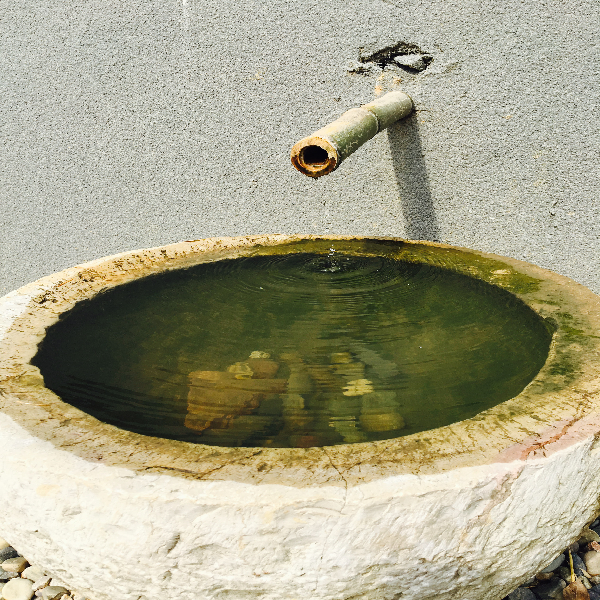

In [0]:
Image.open('/content/drive/My Drive/Book Codes/PyTorch深度学习/Style Transfer/nature.jpg').resize((600,600))

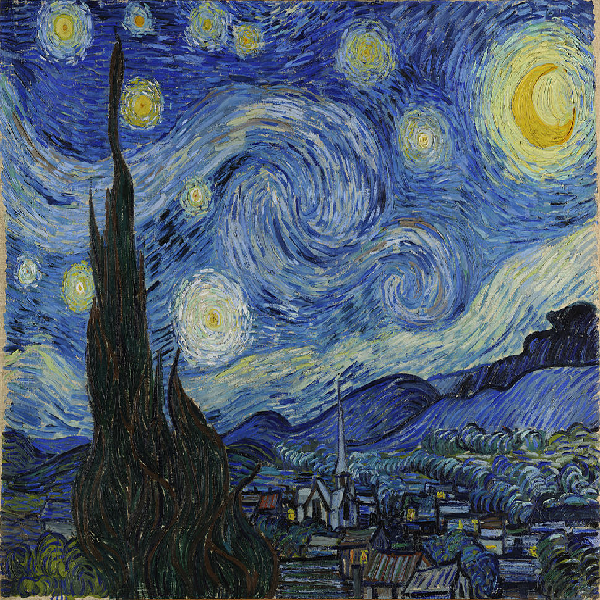

In [0]:
Image.open('/content/drive/My Drive/Book Codes/PyTorch深度学习/Style Transfer/style_pic.jpg').resize((600,600))

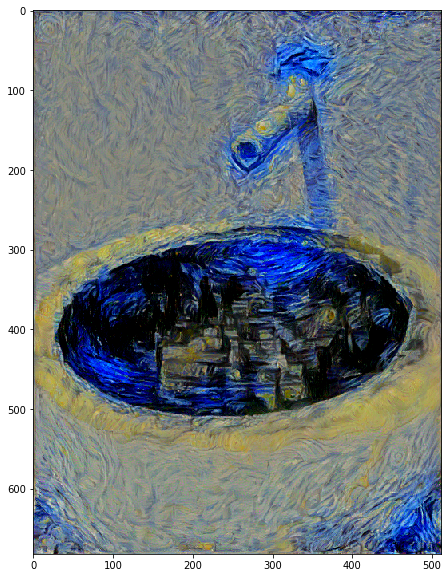

In [0]:
#display result
out_img_hr = postp(opt_img.data[0].cpu().squeeze())

imshow(out_img_hr)
gcf().set_size_inches(10,10)